In [120]:
from nilearn import plotting, datasets, surface
import nibabel as nib
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import src.custom_plotting as cp
import seaborn as sns

fsaverage = datasets.fetch_surf_fsaverage()
cmap = sns.color_palette('magma', as_cmap=True)

In [121]:
def correct(ps_, rs_, p_crit=5e-2):
    sig_bool, ps_corrected, _, _ = multipletests(ps_, alpha=p_crit, method='fdr_bh')
    indices = np.where(sig_bool)[0]
    return sig_bool, rs_[indices].min()


def filter_r(rs, ps):
    # remove nan
    indices = np.isnan(rs)
    rs[indices] = 0
    ps[indices] = 1

    # correct
    ps, threshold = correct(ps, rs)
    ps = np.invert(ps)
    indices = np.where(ps)[0]
    rs[indices] = 0.
    rs_mask = np.copy(rs)
    rs_mask[rs != 0.] = 1.
    return rs, rs_mask, threshold

In [122]:
loc_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/raw/localizer_stats'
stat_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/interim/VoxelPermutation'
mask_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/interim/Reliability'
tasks = ['tom', 'SIpSTS', 'FBOS', 'FBOS', 'biomotion']
afni_labels = ['Belief-Photo_GLT#0_Tstat', 'Interact-Non_GLT#0_Tstat',
               'Faces-Obj_GLT#0_Tstat', 'Bodies-Obj_GLT#0_Tstat',
               'Bio-Trans_GLT#0_Tstat']
titles = ['ToM', 'SIpSTS', 'Faces', 'Bodies', 'Biomotion']
sids = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

In [123]:
i_task = -1
i_sid = 2
feature = 'arousal'

In [124]:
# mask_im = nib.load(f'{mask_dir}/{sids[i_sid]}_set-test_stat-rho_statmap.nii.gz')
# mask = np.load(f'{mask_dir}/{sids[i_sid]}_set-test_reliability-mask.npy')
mask_im = nib.load(f'{mask_dir}/sub-all_set-test_stat-rho_statmap.nii.gz')
mask = np.load(f'{mask_dir}/sub-all_set-test_reliability-mask.npy')

In [136]:
brik = nib.load(f'{loc_dir}/{sids[i_sid]}.{tasks[i_task]}.results/stats.{sids[i_sid]}.{tasks[i_task]}+tlrc.BRIK')
labels = brik.header.get_volume_labels()
loc = np.array(brik.dataobj)[..., labels.index(afni_labels[i_task])]

# Make a nifti object
loc_img = nib.Nifti1Image(loc, brik.affine, brik.header)

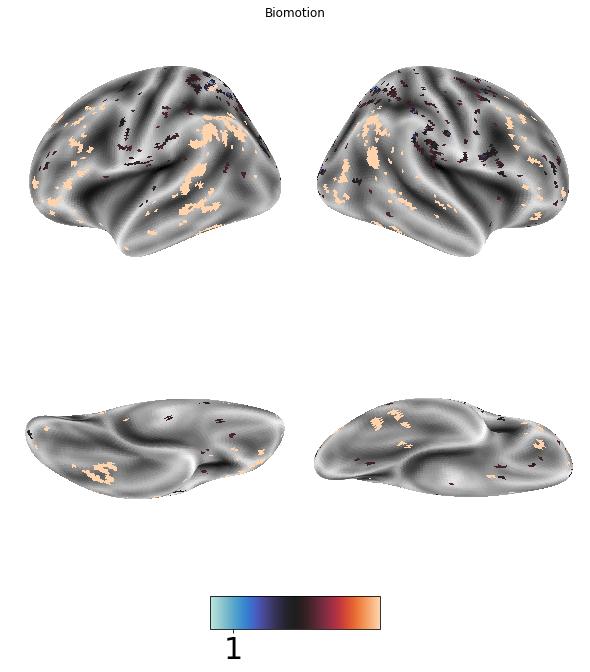

In [137]:
texture = {'left': surface.vol_to_surf(loc_img, fsaverage['pial_left'],
                                       interpolation='nearest'),
           'right': surface.vol_to_surf(loc_img, fsaverage['pial_right'],
                                        interpolation='nearest')}

cp.plot_surface_stats(fsaverage, texture,
                      # roi=self.roi_parcel,
                      cmap=sns.color_palette('icefire', as_cmap=True),
                      modes=['lateral', 'ventral'],
                      # output_file=f'{self.figure_dir}/sub-{self.sid}.png',
                      threshold=stats.norm.isf(0.05),
                      vmax=1.,
                      title=titles[i_task])

In [127]:
# Filter the significant voxels and the ones that are greater than 0
loc[loc < stats.norm.isf(0.05)] = 0.
loc[loc < 0] = 0.

# Make binary
loc[loc != 0] = 1.
loc = loc.astype('bool').flatten()

In [128]:
# base = f'{stat_dir}/{sids[i_sid]}_model-{feature}_predict-all_control-conv2_pca_before_regression-False'
base = f'{stat_dir}/{sids[i_sid]}_feature-{feature}_control-conv2_pca_before_regression-False'
rs = np.load(f'{base}_rs.npy')
ps = np.load(f'{base}_ps.npy')

rs, _, threshold = filter_r(rs, ps)
rs = cp.mkNifti(rs, mask, mask_im, nii=False)

In [129]:
i = np.where(np.invert(loc))
rs[i] = 0.
rs = nib.Nifti1Image(rs.reshape(mask_im.shape), affine=mask_im.affine)

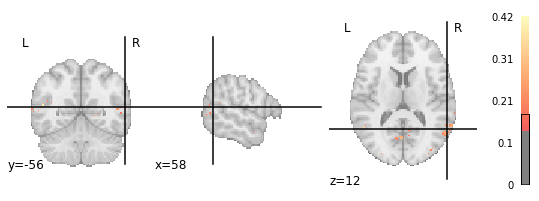

In [130]:
plotting.plot_stat_map(rs, threshold=threshold,
                  cmap=cmap)

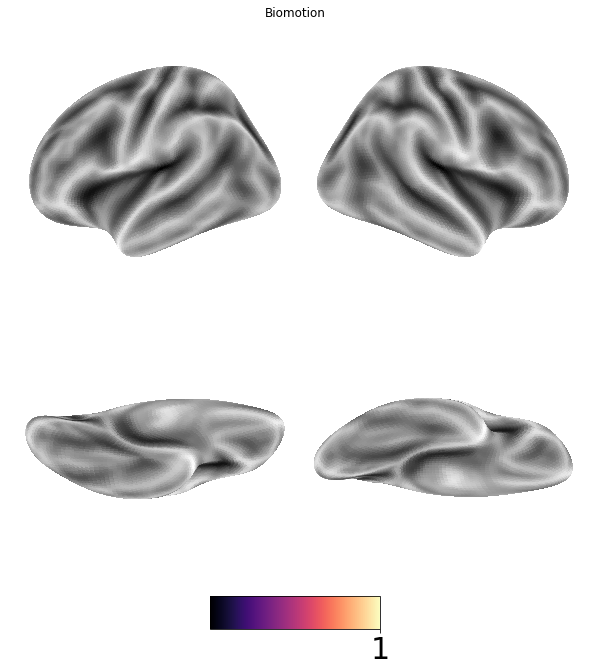

In [131]:
texture = {'left': surface.vol_to_surf(rs, fsaverage['pial_left'],
                                       interpolation='nearest'),
           'right': surface.vol_to_surf(rs, fsaverage['pial_right'],
                                        interpolation='nearest')}

cp.plot_surface_stats(fsaverage, texture,
                      # roi=self.roi_parcel,
                      cmap=cmap,
                      modes=['lateral', 'ventral'],
                      # output_file=f'{self.figure_dir}/sub-{self.sid}.png',
                      threshold=threshold,
                      vmax=1.,
                      title=titles[i_task])